In [ ]:
!pip install opencv-python matplotlib numpy paddlepaddle "paddleocr>=2.7" seaborn

In [61]:
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import pandas as pd
import re
import random
from datetime import datetime
import json
import csv
import glob
from paddleocr import PaddleOCR
from collections import defaultdict
from tqdm import tqdm

In [3]:
BASE = "train"
IMG_DIR = os.path.join(BASE, "img")
BOX_DIR = os.path.join(BASE, "box")

In [4]:
if os.path.exists(IMG_DIR):
    print("Files in IMG_DIR:", os.listdir(IMG_DIR)[:5])
else:
    print(f"Error: Folder {IMG_DIR} tidak ditemukan.")

Files in IMG_DIR: ['X00016469612.jpg', 'X00016469619.jpg', 'X00016469620.jpg', 'X00016469622.jpg', 'X00016469623.jpg']


In [5]:
sample_name = os.listdir(IMG_DIR)[0].split(".")[0]
img_path = os.path.join(IMG_DIR, f"{sample_name}.jpg")
box_path = os.path.join(BOX_DIR, f"{sample_name}.txt")

print("img_path:", img_path)
print("box_path:", box_path)

img_path: train\img\X00016469612.jpg
box_path: train\box\X00016469612.txt


In [6]:
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

In [7]:
boxes = []
if os.path.exists(box_path):
    with open(box_path, "r", encoding="utf-8") as f:
        for line in f:
            parts = line.strip().split(',')
            coords = list(map(int, parts[:8]))
            text = ",".join(parts[8:])
            pts = np.array(coords).reshape(4, 2)
            boxes.append((pts, text))

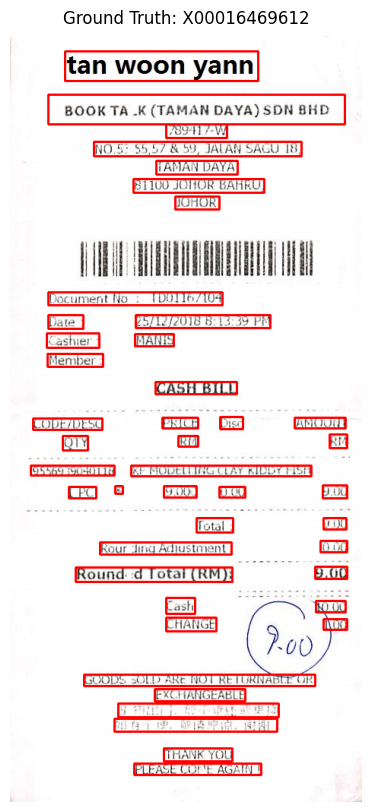

In [8]:
img_copy = img.copy()
for pts, text in boxes:
    cv2.polylines(img_copy, [pts], isClosed=True, color=(255, 0, 0), thickness=2)

# Tampilkan
plt.figure(figsize=(10,10))
plt.imshow(img_copy)
plt.axis("off")
plt.title(f"Ground Truth: {sample_name}")
plt.show()

In [9]:
image_files = os.listdir(IMG_DIR)
num_samples = 6
# Random sample agar tidak bosan melihat gambar yang sama
selected_files = random.sample(image_files, num_samples)

In [10]:
def load_annotation(box_path):
    boxes = []
    if os.path.exists(box_path):
        with open(box_path, "r", encoding="utf-8") as f:
            for line in f:
                parts = line.strip().split(',')
                try:
                    coords = list(map(int, parts[:8]))
                    pts = np.array(coords).reshape(4, 2)
                    text = ",".join(parts[8:])
                    boxes.append((pts, text))
                except:
                    continue # Skip line error
    return boxes

In [11]:
cols = 2
rows = (num_samples + cols - 1) // cols 

plt.figure(figsize=(20, 10 * rows))

<Figure size 2000x3000 with 0 Axes>

<Figure size 2000x3000 with 0 Axes>

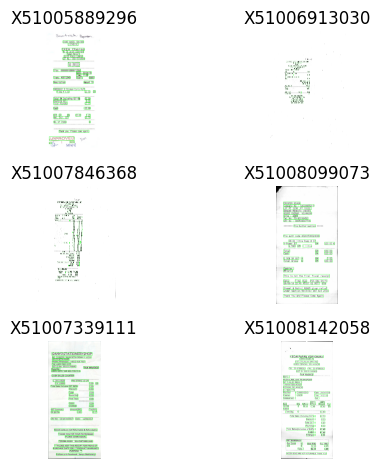

In [12]:
for idx, img_file in enumerate(selected_files):
    sample_name = img_file.split(".")[0]
    i_path = os.path.join(IMG_DIR, img_file)
    b_path = os.path.join(BOX_DIR, f"{sample_name}.txt")

    img_data = cv2.imread(i_path)
    if img_data is None: continue
    img_data = cv2.cvtColor(img_data, cv2.COLOR_BGR2RGB)

    ann_boxes = load_annotation(b_path)
    
    # Draw boxes
    for pts, text in ann_boxes:
        cv2.polylines(img_data, [pts], True, (0, 255, 0), 2) # Hijau untuk GT

    plt.subplot(rows, cols, idx + 1)
    plt.imshow(img_data)
    plt.title(sample_name, fontsize=12)
    plt.axis("off")

plt.tight_layout()
plt.show()

In [13]:
def normalize_text(s):
    s = str(s).replace('\ufffd', '').strip()
    return re.sub(r'\s+', ' ', s)

In [14]:
def poly_centroid(poly):
    cx = int(np.mean(poly[:,0])) # Rata-rata sumbu X
    cy = int(np.mean(poly[:,1])) # Rata-rata sumbu Y
    return cx, cy

In [15]:
def extract_money(s):
    """Mencari angka uang dalam string (misal: 'RM 12.50' -> 12.50)."""
    s_clean = s.replace(',', '') # Hapus pemisah ribuan (1,000 -> 1000)
    # Cari pola angka desimal (prioritas)
    m = re.search(r"\d+\.\d{2}", s_clean) 
    if not m:
        # Jika tidak ada desimal, cari angka biasa
        m = re.search(r"\d+", s_clean)
    return float(m.group()) if m else None

In [16]:
def group_rows(items, y_tol=15):
    """Mengelompokkan kata-kata menjadi baris berdasarkan posisi vertikal (cy)."""
    # 1. Urutkan semua kata berdasarkan posisi Y (dari atas ke bawah)
    items_sorted = sorted(items, key=lambda x: x['cy'])
    
    rows = []
    for it in items_sorted:
        placed = False
        # 2. Cek apakah kata ini sejajar dengan baris yang sudah ada?
        for row in rows:
            # Jika selisih Y <= toleransi (misal 15 pixel), anggap satu baris
            if abs(it['cy'] - row['cy_mean']) <= y_tol:
                row['items'].append(it)
                # Update rata-rata posisi Y baris tersebut
                row['cy_mean'] = sum(i['cy'] for i in row['items']) / len(row['items'])
                placed = True
                break
        
        # 3. Jika tidak sejajar dengan baris manapun, buat baris baru
        if not placed:
            rows.append({'items':[it], 'cy_mean': it['cy']})
    
    # 4. Dalam setiap baris, urutkan kata dari Kiri ke Kanan (xmin)
    for row in rows:
        row['items'] = sorted(row['items'], key=lambda x: x['xmin'])
    
    return rows

In [17]:
def row_to_string(row):
    """Menggabungkan list kata dalam satu baris menjadi satu string panjang."""
    full_text = " ".join([it['text'] for it in row['items']])
    return {
        'text': full_text,
        'cy': row.get('cy_mean'),
        'items': row['items'] # Simpan metadata asli untuk referensi
    }

In [18]:
def classify_row(text: str) -> str:
    t = text.lower()

    summary_kw = [
        "total", "subtotal", "cash", "change",
        "balance", "rounding", "gst", "tax", "visa"
    ]

    footer_kw = [
        "thank you", "visit again", "come again"
    ]

    # SUMMARY
    if any(k in t for k in summary_kw):
        return "summary"

    # FOOTER
    if any(k in t for k in footer_kw):
        return "footer"

    # ITEM → ada harga
    if re.search(r"\d+\.\d{2}", t):
        return "item"

    # HEADER default
    return "header"

In [20]:
def extract_company(rows_merged):
    # Keyword umum nama PT/Toko
    keywords = ["sdn", "bhd", "trading", "enterprise", "mart", "store", "cafe"]
    
    # Ambil 5 baris teratas saja
    for r in rows_merged[:5]:
        text = r["text"].strip()
        # Skip jika isinya cuma angka/simbol
        if len(text) < 3 or re.fullmatch(r"[0-9\.\-:\s]+", text): 
            continue 
        
        # Jika mengandung keyword atau huruf kapital semua, kemungkinan itu nama toko
        if any(k in text.lower() for k in keywords) or text.isupper():
            return text
            
    return ""

In [19]:
def clean_company_name(name):
    if name is None:
        return "UNKNOWN"
    
    name = str(name).strip()
    if not name:
        return "UNKNOWN"
    
    name = str(name).upper()
    
    noise_keywords = [
        "THANK YOU", "VISIT AGAIN", "WELCOME",
        "GST", "TAX INVOICE", "RECEIPT"
        ]
    if any(k in name for k in noise_keywords):
        return "UNKNOWN"
    
    if re.match(r'^\d+[,.\s]+[A-Z\s]{5,}', name):
        return "UNKNOWN"
    
    suffix_patterns = [
        r'\bSDN\.?\s*BHD\.?$',
        r'\bENTERPRISE$',
        r'\bTRADING$',
        r'\bRESTAURANT$',
        r'\bSHOP$',
        r'\bSTORE$'
        ]
    for pat in suffix_patterns:
        name = re.sub(pat, '', name).strip()
    
    # Hapus kurung
    name = re.sub(r'\([^)]*$', '', name)
    
    # Hapus registration number
    name = re.sub(r'\(\d+[^)]*\)', '', name)
    
    name = re.sub(r'\s+', ' ', name).strip()

    if len(name) < 3 and not re.search(r'[A-Z]{2,}', name):
        return "UNKNOWN"
    
    return name

In [21]:
def extract_date(rows_merged):
    # Pola regex tanggal (DD/MM/YYYY, YYYY-MM-DD, dll)
    patterns = [
        r"\d{1,2}[\/\-]\d{1,2}[\/\-]\d{2,4}",
        r"\d{1,2}\s+(?:JAN|FEB|MAR|APR|MAY|JUN|JUL|AUG|SEP|OCT|NOV|DEC)[a-z]*\s+\d{2,4}"
    ]
    # Gabungkan seluruh teks untuk pencarian regex global
    full_text = " ".join([r['text'] for r in rows_merged])
    
    for pat in patterns:
        m = re.search(pat, full_text, re.IGNORECASE)
        if m: return m.group(0)
    return None

In [22]:
def extract_total(rows_merged):
    summary = {"total": 0.0}
    # Cari dari bawah ke atas (karena Total biasanya di bawah)
    for r in reversed(rows_merged):
        txt_low = r['text'].lower()
        if "total" in txt_low and "sub" not in txt_low:
            val = extract_money(r['text'])
            if val:
                summary["total"] = val
                break # Ketemu total, berhenti loop
    return summary

In [23]:
def is_summary_row(text):
    """Cek apakah baris ini adalah Summary (Total/Tax), bukan barang."""
    keywords = ['total', 'cash', 'change', 'tax', 'gst', 'rounding', 'balance', 'visa']
    return any(k in text.lower() for k in keywords)

In [24]:
NON_ITEM_KEYWORDS = [
    "total", "subtotal", "cash", "change",
    "rounding", "tax", "gst", "service",
    "visa", "master", "balance", "discount",
    "amount", "paid"
]

In [25]:
def is_non_item_line(text: str) -> bool:
    t = text.lower()
    return any(k in t for k in NON_ITEM_KEYWORDS)

In [26]:
def extract_prices(text):
    return [float(p) for p in re.findall(r"\d+\.\d{2}", text)]

# **GROUP 1 — Confidence & scoring**

In [ ]:
# def merchant_position_signal(rows_merged, company_raw):
#     for idx, r in enumerate(rows_merged[:5]):
#         if company_raw and any(w in r["text"] for w in company_raw.split()):
#             if idx <= 2:
#                 return 1.0
#             elif idx <= 4:
#                 return 0.7
#     return 0.0


In [ ]:
# def alpha_ratio_signal(text):
#     if not text:
#         return 0.0
#     alpha = sum(c.isalpha() for c in text)
#     return min(alpha / max(len(text), 1), 1.0)

In [ ]:
# MERCHANT_POSITIVE = [
#     "SDN", "BHD", "TRADING", "ENTERPRISE",
#     "MART", "STORE", "CAFE"
# ]

# MERCHANT_NEGATIVE = [
#     "JALAN", "LOT", "NO", "TEL", "FAX", "GST"
# ]

In [ ]:
# def keyword_signal(text):
#     t = text.upper()
#     score = 0.0

#     if any(k in t for k in MERCHANT_POSITIVE):
#         score += 1.0
#     if any(k in t for k in MERCHANT_NEGATIVE):
#         score -= 1.0

#     return max(score, 0.0)

In [ ]:
# def clean_valid_signal(clean_name):
#     if not clean_name:
#         return 0.0
#     if clean_name == "UNKNOWN":
#         return 0.0
#     if len(clean_name) < 3:
#         return 0.0
#     return 1.0

In [ ]:
# def compute_merchant_confidence(rows_merged, company_raw, company_clean):
#     s_position = merchant_position_signal(rows_merged, company_raw)
#     s_alpha = alpha_ratio_signal(company_raw)
#     s_keyword = keyword_signal(company_raw)
#     s_clean = clean_valid_signal(company_clean)

#     score = (
#         0.35 * s_position +
#         0.25 * s_alpha +
#         0.25 * s_keyword +
#         0.15 * s_clean
#     )

#     return {
#         "score": round(score, 3),
#         "signals": {
#             "position": s_position,
#             "alpha_ratio": round(s_alpha, 3),
#             "keyword": s_keyword,
#             "clean_valid": s_clean
#         }
#     }

In [ ]:
# def date_regex_signal(date_raw):
#     return 1.0 if date_raw else 0.0

In [ ]:
# def date_parse_signal(date_clean):
#     return 1.0 if pd.notna(date_clean) else 0.0

In [ ]:
# def date_range_signal(date_clean):
#     if pd.isna(date_clean):
#         return 0.0
#     year = date_clean.year
#     current_year = datetime.now().year
#     return 1.0 if 2000 <= year <= current_year else 0.0

In [ ]:
# def compute_date_confidence(date_raw, date_clean):
#     s_regex = date_regex_signal(date_raw)
#     s_parse = date_parse_signal(date_clean)
#     s_range = date_range_signal(date_clean)

#     score = (
#         0.5 * s_regex +
#         0.3 * s_parse +
#         0.2 * s_range
#     )

#     return {
#         "score": round(score, 3),
#         "signals": {
#             "regex_found": s_regex,
#             "parse_valid": s_parse,
#             "reasonable_range": s_range
#         }
#     }

# **GROUP 2 — Item confidence & semantic quality**

In [ ]:
# def item_alpha_ratio_signal(desc):
#     alpha = sum(c.isalpha() for c in desc)
#     return min(alpha / max(len(desc), 1), 1.0)

In [ ]:
# def price_consistency_signal(qty, unit_price, line_total):
#     if qty <= 0 or unit_price <= 0 or line_total <= 0:
#         return 0.0

#     expected = qty * unit_price
#     diff = abs(expected - line_total)

#     if diff < 0.01:
#         return 1.0
#     elif diff < 0.1:
#         return 0.5
#     else:
#         return 0.0

In [ ]:
# def item_position_signal(row_idx, total_rows):
#     ratio = row_idx / max(total_rows - 1, 1)

#     if 0.2 <= ratio <= 0.8:
#         return 1.0
#     elif 0.1 <= ratio <= 0.9:
#         return 0.5
#     else:
#         return 0.0

In [ ]:
# def item_length_signal(desc):
#     if len(desc) >= 5:
#         return 1.0
#     elif len(desc) >= 3:
#         return 0.5
#     else:
#         return 0.0

In [ ]:
# ITEM_BLACKLIST_KEYWORDS = [
#     # Header / table
#     "item", "qty", "quantity", "price", "s/price", "unit price",
    
#     # Summary / payment
#     "total", "subtotal", "tax", "gst", "rounding",
#     "payment", "paid", "cash", "change", "balance",
    
#     # Footer
#     "thank", "served", "receipt", "welcome",

#     # Noise
#     "amount", "visa", "master", "debit", "credit"
# ]


In [ ]:
# def blacklist_keyword_penalty(desc: str):
#     if not desc:
#         return 0.0

#     t = desc.lower()
#     for kw in ITEM_BLACKLIST_KEYWORDS:
#         if kw in t:
#             return 0.0
#     return 1.0

In [ ]:
# def word_count_signal(desc):
#     words = [w for w in desc.split() if w.isalpha()]
#     if len(words) >= 2:
#         return 1.0
#     elif len(words) == 1:
#         return 0.5
#     return 0.0

In [ ]:
# def digit_ratio_penalty(desc):
#     digits = sum(c.isdigit() for c in desc)
#     ratio = digits / max(len(desc), 1)

#     if ratio < 0.2:
#         return 1.0
#     elif ratio < 0.4:
#         return 0.5
#     else:
#         return 0.0

In [ ]:
# def symbol_noise_penalty(desc):
#     symbols = sum(not c.isalnum() and not c.isspace() for c in desc)
#     ratio = symbols / max(len(desc), 1)

#     if ratio < 0.1:
#         return 1.0
#     elif ratio < 0.2:
#         return 0.5
#     else:
#         return 0.0

In [ ]:
# GENERIC_ITEM_WORDS = [
#     "item", "product", "goods", "price", "qty", "amount"
# ]

# def generic_word_penalty(desc):
#     t = desc.lower()
#     words = t.split()

#     if all(w in GENERIC_ITEM_WORDS for w in words):
#         return 0.0
#     return 1.0

In [ ]:
# def semantic_quality_signal(desc):
#     s_word = word_count_signal(desc)
#     s_digit = digit_ratio_penalty(desc)
#     s_symbol = symbol_noise_penalty(desc)
#     s_generic = generic_word_penalty(desc)

#     score = (
#         0.35 * s_word +
#         0.25 * s_digit +
#         0.20 * s_symbol +
#         0.20 * s_generic
#     )

#     return {
#         "score": round(score, 3),
#         "signals": {
#             "word_count": s_word,
#             "digit_ratio": s_digit,
#             "symbol_noise": s_symbol,
#             "generic_word": s_generic
#         }
#     }

In [ ]:
# def compute_item_confidence(
#     desc,
#     qty,
#     unit_price,
#     line_total,
#     row_idx,
#     total_rows,
# ):
#     s_alpha = item_alpha_ratio_signal(desc)
#     s_price = price_consistency_signal(qty, unit_price, line_total)
#     s_pos = item_position_signal(row_idx, total_rows)
#     s_len = item_length_signal(desc)
#     s_blacklist = blacklist_keyword_penalty(desc)
#     s_semantic = semantic_quality_signal(desc)["score"]

#     score = (
#         0.20 * s_alpha +
#         0.30 * s_price +
#         0.15 * s_pos +
#         0.10 * s_len +
#         0.15 * s_blacklist +
#         0.10 * s_semantic
#     )

#     return {
#         "score": round(score, 3),
#         "signals": {
#             "alpha_ratio": round(s_alpha, 3),
#             "price_consistency": s_price,
#             "position": s_pos,
#             "length": s_len,
#             "blacklist_pass": s_blacklist,
#             "semantic_quality": s_semantic
#         }
#     }

In [ ]:
# def extract_line_items(rows_merged):
#     items = []
#     total_rows = len(rows_merged)

#     for idx, r in enumerate(rows_merged):
#         text = r['text']

#         # 1. Skip non-item rows (summary, footer, payment)
#         if is_non_item_line(text):
#             continue

#         # 2. Extract prices
#         prices = extract_prices(text)
#         if not prices:
#             continue

#         # 3. Clean description FIRST
#         desc = re.sub(r"\d+\.\d{2}", "", text)
#         desc = re.sub(r"\b[xX@]\b", "", desc)
#         desc = re.sub(r"\s+", " ", desc).strip()

#         if len(desc) < 3:
#             continue

#         alpha_ratio = sum(c.isalpha() for c in desc) / max(len(desc), 1)
#         if alpha_ratio < 0.3:
#             continue

#         # 4. Default price assumption
#         qty = 1
#         unit_price = prices[-1]
#         line_total = prices[-1]

#         # 5. Qty inference ONLY if indicator exists
#         has_qty_indicator = re.search(r"\b(\d+)\s*[xX@]\s*\d", text)

#         if has_qty_indicator and len(prices) >= 2:
#             possible_unit = prices[-2]
#             possible_total = prices[-1]

#             for q in range(2, 10):
#                 if abs(possible_unit * q - possible_total) < 0.01:
#                     qty = q
#                     unit_price = possible_unit
#                     line_total = possible_total
#                     break

#         if line_total <= 0:
#             continue
        
#         confidence = compute_item_confidence(
#             desc,
#             qty,
#             unit_price,
#             line_total,
#             idx,
#             total_rows
#         )

#         items.append({
#             "description": desc,
#             "qty": qty,
#             "unit_price": round(unit_price, 2),
#             "line_total": round(line_total, 2),
#             "row_idx": idx,           # penting untuk confidence
#             "row_ratio": round(idx / max(total_rows - 1, 1), 3),
#             "confidence": confidence
#         })

#     return items

# **GROUP 4 — build_receipt_json**

In [50]:
def build_receipt_json(
    filename,
    company_raw,
    company_clean,
    date_clean,
    items,
    summary,
    merchant_conf,
    date_conf
    ):
    
    return {
        "filename": filename,

        "merchant": {
            "raw": company_raw,
            "clean": company_clean,
            "confidence": merchant_conf
        },

        "transaction": {
            "date": date_clean.isoformat() if pd.notna(date_clean) else None,
            "currency": "MYR",
            "confidence": date_conf
        },

        "items": items,

        "summary": {
            "subtotal": None,
            "tax": None,
            "total": summary.get("total"),
            "cash": None,
            "change": None
        },

        "meta": {
            "num_items": len(items),
            "ocr_engine": "PaddleOCR",
            "version": "receipt_json_v1"
        }
    }

In [ ]:
def process_receipt(img_path):
    try:
        # Gunakan method .predict() sesuai saran warning, atau tetap .ocr()
        # PaddleOCR wrapper biasanya tetap mensupport .ocr()
        result = ocr.predict(img_path)
        
        raw_items = []
        if result is None or len(result) == 0:
            return None

        res_obj = result[0]
        
        # --- LOGIKA PARSING (YANG SUDAH BERHASIL) ---
        if isinstance(res_obj, dict): # PaddleX style
            keys_poly = ['dt_polys', 'rec_polys', 'polys', 'boxes']
            keys_text = ['rec_text', 'rec_texts', 'texts', 'text']
            
            key_poly = next((k for k in keys_poly if k in res_obj), None)
            key_text = next((k for k in keys_text if k in res_obj), None)

            if key_poly and key_text:
                polys = res_obj[key_poly]
                texts = res_obj[key_text]
                # Default score 0.99 jika key score tidak ketemu
                scores = [0.99] * len(texts) 
                
                for poly_raw, text, score in zip(polys, texts, scores):
                    poly = np.array(poly_raw, dtype=np.float32).reshape(-1, 2)
                    cx, cy = poly_centroid(poly)
                    raw_items.append({
                        'text': normalize_text(text),
                        'poly': poly,
                        'cx': cx, 'cy': cy,
                        'xmin': int(np.min(poly[:, 0])),
                        'xmax': int(np.max(poly[:, 0]))
                    })
        
        elif isinstance(res_obj, list): # Legacy style
            for line in res_obj:
                poly = np.array(line[0], dtype=np.float32).reshape(-1, 2)
                content = line[1]
                text = content[0] if isinstance(content, (list, tuple)) else str(content)
                cx, cy = poly_centroid(poly)
                raw_items.append({
                    'text': normalize_text(text),
                    'poly': poly,
                    'cx': cx, 'cy': cy,
                    'xmin': int(np.min(poly[:, 0])),
                    'xmax': int(np.max(poly[:, 0]))
                })

        # --- GROUPING & EXTRACTING ---
        if raw_items:
            rows = group_rows(raw_items, y_tol=12) # Grouping baris
            rows_merged = [row_to_string(r) for r in rows] # Gabung string
            
            for r in rows_merged:
                r['type'] = classify_row(r['text'])
            
            # Ekstrak Informasi Penting
            company_raw = extract_company(rows_merged)
            company_clean = clean_company_name(company_raw)
            date_raw = extract_date(rows_merged)
            date_clean = pd.to_datetime(date_raw, dayfirst=True, errors='coerce')
            summary = extract_total(rows_merged)
            items = extract_line_items(rows_merged)
            merchant_conf = compute_merchant_confidence(
                rows_merged,
                company_raw,
                company_clean
            )

            date_conf = compute_date_confidence(
                date_raw,
                date_clean
            )

            receipt = build_receipt_json(
                filename=os.path.basename(img_path),
                company_raw=company_raw,
                company_clean=company_clean,
                date_clean=date_clean,
                items=items,
                summary=summary,
                merchant_conf=merchant_conf,
                date_conf=date_conf
            )

            return receipt
            
    except Exception as e:
        print(f"Error processing {img_path}: {e}")
        return None
    
    return None

In [52]:
ocr = PaddleOCR(use_textline_orientation=True, lang='en')

c:\work\Learning OCR\.venv\Lib\site-packages\paddle\utils\cpp_extension\extension_utils.py:718: UserWarning: No ccache found. Please be aware that recompiling all source files may be required. You can download and install ccache from: https://github.com/ccache/ccache/blob/master/doc/INSTALL.md
  warnings.warn(warning_message)
Creating model: ('PP-LCNet_x1_0_doc_ori', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `C:\Users\user\.paddlex\official_models\PP-LCNet_x1_0_doc_ori`.
Creating model: ('UVDoc', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `C:\Users\user\.paddlex\official_models\UVDoc`.
Creating model: ('PP-LCNet_x1_0_textline_ori', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `C:\Users\user\.paddlex\official_models\PP-LCNet_x1_0_textline_ori`.
Creating model: ('PP-OCRv5_server_det', None)
Model files 

In [53]:
all_results = []
image_files = sorted(glob.glob(os.path.join(IMG_DIR, "*.jpg")))

print(f"Ditemukan {len(image_files)} gambar. Memulai proses...")

# Kita coba 10 gambar pertama dulu agar tidak menunggu terlalu lama
for idx, img_file in enumerate(image_files[:20]): 
    print(f"[{idx+1}/{len(image_files[:20])}] Processing: {os.path.basename(img_file)}")
    
    data = process_receipt(img_file)
    if data:
        all_results.append(data)

Ditemukan 626 gambar. Memulai proses...
[1/20] Processing: X00016469612.jpg


C:\Users\user\AppData\Local\Temp\ipykernel_20432\1937830418.py:5: DeprecationWarning: Please use `predict` instead.
  result = ocr.ocr(img_path)


[2/20] Processing: X00016469619.jpg
[3/20] Processing: X00016469620.jpg
[4/20] Processing: X00016469622.jpg
[5/20] Processing: X00016469623.jpg
[6/20] Processing: X00016469669.jpg
[7/20] Processing: X00016469672.jpg
[8/20] Processing: X00016469676.jpg
[9/20] Processing: X51005200938.jpg
[10/20] Processing: X51005230617.jpg
[11/20] Processing: X51005255805.jpg
[12/20] Processing: X51005268200.jpg
[13/20] Processing: X51005268262.jpg
[14/20] Processing: X51005268400.jpg


C:\Users\user\AppData\Local\Temp\ipykernel_20432\1937830418.py:64: UserWarning: Parsing dates in %m/%d/%Y format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  date_clean = pd.to_datetime(date_raw, dayfirst=True, errors='coerce')


[15/20] Processing: X51005268472.jpg
[16/20] Processing: X51005301659.jpg
[17/20] Processing: X51005301661.jpg
[18/20] Processing: X51005301667.jpg
[19/20] Processing: X51005303661.jpg
[20/20] Processing: X51005306399.jpg


In [54]:
# output_file = "ex_ocr_results.json"
# with open(output_file, "w") as f:
#     json.dump(all_results, f, indent=4)

# print(f"\nSelesai! Hasil disimpan di '{output_file}'.")

In [55]:
# df_final = pd.DataFrame(all_results)
# df_final

In [57]:
def assign_label(conf):
    if conf >= 0.85:
        return 1        # ITEM
    elif conf <= 0.25:
        return 0        # NON-ITEM
    else:
        return -1

In [58]:
rows = []

for receipt in all_results:   # JSON hasil OCR Anda
    total_rows = receipt["meta"]["num_items"]

    for item in receipt["items"]:
        conf = item["confidence"]["score"]
        label = assign_label(conf)

        if label == -1:
            continue  # ignore ambiguous rows

        signals = item["confidence"]["signals"]

        rows.append({
            "text": item["description"],
            "alpha_ratio": signals["alpha_ratio"],
            "row_ratio": item["row_ratio"],
            "price_count": len(extract_prices(item["description"])),
            "blacklist_pass": signals["blacklist_pass"],
            "price_consistency": signals["price_consistency"],
            "item_length": signals["length"],
            "position_signal": signals["position"],
            "label": label
        })

In [59]:
df_signals = pd.DataFrame(rows)
df_signals

,text,alpha_ratio,row_ratio,price_count,blacklist_pass,price_consistency,item_length,position_signal,label
0,CDISC % -,0.556,0.640,0,1.0,1.0,1.0,1.0,1
1,Plastic 2,0.778,0.611,0,1.0,1.0,1.0,1.0,1
2,2 ChicMcMuffin,0.857,0.515,0,1.0,1.0,1.0,1.0,1
3,1 M Porridge,0.750,0.545,0,1.0,1.0,1.0,1.0,1
4,1 BM 2HotCakes,0.714,0.576,0,1.0,1.0,1.0,1.0,1
5,TOAAL,1.000,0.382,0,1.0,1.0,1.0,1.0,1
6,ZRL,1.000,0.321,0,1.0,1.0,0.5,1.0,1
7,1 * RM C UNI ( )=RM,0.421,0.500,0,1.0,1.0,1.0,1.0,1
8,CA. RM,0.667,0.714,0,1.0,1.0,1.0,1.0,1
9,2 * RM UNI ( :,0.357,0.519,0,1.0,1.0,1.0,1.0,1


In [60]:
df_signals.value_counts("label")

label
1    15
Name: count, dtype: int64

In [62]:
def export_labeling_csv(
    all_receipt_rows,
    output_path="labeling_dataset.csv",
    max_rows=500
):
    """
    all_receipt_rows: list of dict
        [
          {
            "image_id": "...",
            "rows": rows_merged
          },
          ...
        ]
    """

    records = []

    for rec in all_receipt_rows:
        image_id = rec["image_id"]
        rows = rec["rows"]
        total_rows = len(rows)

        for idx, r in enumerate(rows):
            text = r["text"].strip()
            if len(text) < 3:
                continue

            alpha = sum(c.isalpha() for c in text)
            char_len = len(text)
            alpha_ratio = alpha / max(char_len, 1)

            records.append({
                "image_id": image_id,
                "text": text,
                "row_idx": idx,
                "row_ratio": round(idx / max(total_rows - 1, 1), 3),
                "char_len": char_len,
                "alpha_ratio": round(alpha_ratio, 3),
                "has_digit": int(any(c.isdigit() for c in text)),
                "label": ""  # <-- DIISI MANUAL
            })

    # Sampling agar tidak kebanyakan
    if len(records) > max_rows:
        records = records[:max_rows]

    # Write CSV
    with open(output_path, "w", newline="", encoding="utf-8") as f:
        writer = csv.DictWriter(
            f,
            fieldnames=records[0].keys()
        )
        writer.writeheader()
        writer.writerows(records)

    print(f"✅ Export selesai: {output_path} ({len(records)} rows)")

In [63]:
all_rows_for_labeling = []

for img_path in image_files[:50]:  # cukup 30–50 receipt
    result = ocr.predict(img_path)
    # ... parsing OCR → raw_items → rows_merged

    all_rows_for_labeling.append({
        "image_id": os.path.basename(img_path),
        "rows": rows_merged
    })

C:\Users\user\AppData\Local\Temp\ipykernel_20432\1234499039.py:4: DeprecationWarning: Please use `predict` instead.
  result = ocr.ocr(img_path)


NameError: name 'rows_merged' is not defined